# WZDx / AZ511 Work Zone Events - Exploratory Data Analysis

This notebook performs exploratory data analysis on the AZ511 Work Zone (WZDx) and related events data stored in the SQLite database `database/az511.db`.

## Goals
1. Inspect database schema & table sizes
2. Explore core `events` table structure & data quality
3. Derive temporal features (start / end / duration / recency)
4. Analyze categorical distributions (EventType, Severity, DirectionOfTravel, IsFullClosure)
5. Spatial inspection (latitude/longitude coverage, quick clustering)
6. Timeline of reporting & last updates
7. Polyline length approximation (if EncodedPolyline present)
8. Identify missing / inconsistent values
9. Save summary artifacts for reuse

---
## 1. Imports & Configuration

In [1]:
# Core imports
import sqlite3, os, json, math
from pathlib import Path
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Display all columns
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

DB_PATH = Path('../database/az511.db')
assert DB_PATH.exists(), f"Database not found at {DB_PATH}"
DB_PATH

PosixPath('../database/az511.db')

## 2. Inspect Database Schema
List tables & counts.

In [2]:
def get_connection():
    return sqlite3.connect(DB_PATH)

def list_tables():
    with get_connection() as conn:
        cur = conn.cursor()
        cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY 1")
        return [r[0] for r in cur.fetchall()]

def table_counts(tables):
    rows = []
    with get_connection() as conn:
        cur = conn.cursor()
        for t in tables:
            try:
                cur.execute(f"SELECT COUNT(*) FROM {t}")
                c = cur.fetchone()[0]
            except Exception as e:
                c = None
            rows.append({'table': t, 'row_count': c})
    return pd.DataFrame(rows)

_tables = list_tables()
print('Tables:', _tables)
counts_df = table_counts(_tables)
counts_df.sort_values('row_count', ascending=False)

Tables: ['events']


table  row_count
0  events      46488

## 3. Load Core Events Table & Basic Profiling
Focus on `events` (AZ511 feed).

In [3]:
with get_connection() as conn:
    events_df = pd.read_sql("SELECT * FROM events", conn)

print(f"Loaded events: {events_df.shape}")
# Peek
events_df.head()

Loaded events: (46488, 30)


ID Organization       RoadwayName DirectionOfTravel  \
0  361395          ERS             US-60              West   
1  378561         RADS           4TH AVE              None   
2  378562         RADS           3RD AVE              None   
3  378620         RADS           24TH ST              None   
4  378642         RADS  INDIAN SCHOOL RD              None   

                                         Description    Reported  LastUpdated  \
0  Turning lane closed on US-60 Westbound from To...  1746244800   1746132016   
1           4TH AVE - road construction - GM, AS, CC  1743404400   1749773824   
2           3RD AVE - road construction - GM, AS, CC  1743404400   1749773824   
3  24TH ST - road construction - Rolling Closure ...  1745899200   1749773824   
4  INDIAN SCHOOL RD - road construction - BO, TR,...  1746514800   1749773824   

    StartDate  PlannedEndDate LanesAffected   Latitude   Longitude  \
0  1746244800    1.749816e+09       No Data  33.644062 -112.357105   
1  1743404400    1.749798e+09       No Data  33.456696 -112.078933   
2  1743404400    1.749798e+09       No Data  33.456691 -112.077687   
3  1745899200    1.749816e+09       No Data  33.441061 -112.034379   
4  1746514800    1.749798e+09       No Data  33.494716 -112.056328   

   LatitudeSecondary  LongitudeSecondary EventType       EventSubType  \
0          33.644658         -112.357868  roadwork  turninglaneclosed   
1                NaN                 NaN  roadwork  road construction   
2                NaN                 NaN  roadwork  road construction   
3                NaN                 NaN  roadwork  road construction   
4                NaN                 NaN  roadwork  road construction   

   IsFullClosure Severity   EncodedPolyline Width Height Length Weight Speed  \
0              0    Minor  kbjlEzvwlTMPiBfC  None   None   None   None  None   
1              0     None              None  None   None   None   None  None   
2              0     None              None  None   None   None   None  None   
3              0     None              None  None   None   None   None  None   
4              0     None              None  None   None   None   None  None   

  DetourPolyline DetourInstructions  \
0           None               None   
1           None               None   
2           None               None   
3           None               None   
4           None               None   

                                          Recurrence  \
0  "<b>Mon, Tue, Wed, Thu, Fri:</b><br/>12:00 AM ...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                                 RecurrenceSchedules  \
0  [{"StartDate": "5/2/2025 9:00:00 PM-07:00:00",...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                                             Details  LaneCount  
0  Turning lane closed on US-60 Westbound from To...        3.0  
1                                               None        NaN  
2                                               None        NaN  
3                                               None        NaN  
4                                               None        NaN

In [4]:
# Basic info & dtypes
info = events_df.dtypes.to_frame('dtype')
info['non_null'] = events_df.notnull().sum()
info['missing_pct'] = 100 - (info['non_null'] / len(events_df) * 100)
info.sort_values('missing_pct', ascending=False).head(15)

dtype  non_null  missing_pct
Weight                object         0   100.000000
Length                object         1    99.997849
Height                object         8    99.982791
DetourPolyline        object        38    99.918258
DetourInstructions    object        38    99.918258
Speed                 object       290    99.376183
Width                 object       561    98.793237
Details               object      2309    95.033127
LongitudeSecondary   float64      3029    93.484340
LatitudeSecondary    float64      3029    93.484340
RecurrenceSchedules   object      3217    93.079935
Recurrence            object      3363    92.765875
EncodedPolyline       object      3592    92.273275
LaneCount            float64     10718    76.944588
Severity              object     10947    76.451988

### 3.1 Core Numeric & Categorical Summaries

In [5]:
numeric_cols = events_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in events_df.columns if c not in numeric_cols and events_df[c].nunique() < 50]

summary_numeric = events_df[numeric_cols].describe().T if numeric_cols else pd.DataFrame()
summary_cats = {c: events_df[c].value_counts().head(10) for c in cat_cols}
print('Numeric columns:', numeric_cols[:10])
summary_numeric.head(10)

Numeric columns: ['Reported', 'LastUpdated', 'StartDate', 'PlannedEndDate', 'Latitude', 'Longitude', 'LatitudeSecondary', 'LongitudeSecondary', 'IsFullClosure', 'LaneCount']


count          mean           std           min  \
Reported            46488.0  1.752808e+09  2.985598e+08 -6.213560e+10   
LastUpdated         46488.0  1.754667e+09  3.387899e+06  1.679600e+09   
StartDate           46488.0  1.752808e+09  2.985598e+08 -6.213560e+10   
PlannedEndDate      35028.0  5.248592e+09  1.030541e+10  1.668121e+09   
Latitude            46485.0  3.341373e+01  5.580200e-01  3.098070e+01   
Longitude           46485.0 -1.119284e+02  5.558572e-01 -1.147753e+02   
LatitudeSecondary    3029.0  3.366920e+01  8.782921e-01  3.135809e+01   
LongitudeSecondary   3029.0 -1.117079e+02  9.288746e-01 -1.145980e+02   
IsFullClosure       46488.0  2.067200e-02  1.422853e-01  0.000000e+00   
LaneCount           10718.0  1.344840e+00  8.358550e-01  1.000000e+00   

                             25%           50%           75%           max  
Reported            1.751545e+09  1.754494e+09  1.756976e+09  7.258144e+09  
LastUpdated         1.752444e+09  1.755025e+09  1.757056e+09  1.759353e+09  
StartDate           1.751545e+09  1.754494e+09  1.756976e+09  7.258144e+09  
PlannedEndDate      1.753830e+09  1.756984e+09  1.759475e+09  3.565934e+10  
Latitude            3.338608e+01  3.345449e+01  3.356613e+01  3.699627e+01  
Longitude          -1.121348e+02 -1.120499e+02 -1.118589e+02 -1.090469e+02  
LatitudeSecondary   3.331308e+01  3.346552e+01  3.384340e+01  3.698741e+01  
LongitudeSecondary -1.121443e+02 -1.118911e+02 -1.113851e+02 -1.090463e+02  
IsFullClosure       0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
LaneCount           1.000000e+00  1.000000e+00  1.000000e+00  8.000000e+00

In [6]:
# Display top categorical distributions
cat_dist_frames = []
for c, vc in summary_cats.items():
    df_tmp = vc.reset_index().rename(columns={'index': c, c: 'count'})
    df_tmp['column'] = c
    cat_dist_frames.append(df_tmp)

cat_summary = pd.concat(cat_dist_frames, ignore_index=True) if cat_dist_frames else pd.DataFrame()
cat_summary.head(20)

count  count             column
0                    RADS  31030       Organization
1                     ERS  10786       Organization
2                  Tucson   3967       Organization
3                Glendale    544       Organization
4                TRAVELIQ    161       Organization
5                    West   3031  DirectionOfTravel
6                    East   3019  DirectionOfTravel
7                   North   1962  DirectionOfTravel
8                   South   1946  DirectionOfTravel
9                 Unknown    912  DirectionOfTravel
10             northbound    184  DirectionOfTravel
11              westbound    137  DirectionOfTravel
12             southbound    110  DirectionOfTravel
13              eastbound    106  DirectionOfTravel
14                   Both     61  DirectionOfTravel
15               roadwork  30397          EventType
16  accidentsAndIncidents  15063          EventType
17               closures    876          EventType
18          specialEvents    135          EventType
19       restrictionClass     17          EventType

## 4. Temporal Features & Activity
Convert epoch-like integer fields to datetime & compute durations.

In [8]:
time_cols = ['Reported','LastUpdated','StartDate','PlannedEndDate']
for c in time_cols:
    if c in events_df.columns:
        # Assume milliseconds if values too large; adjust
        series = events_df[c].dropna()
        if series.empty:
            events_df[c + '_dt'] = pd.NaT
            continue
        median_val = series.median()
        # Heuristic: if > 10^12 treat as ms, >10^9 treat as s
        if median_val > 1e12:
            events_df[c + '_dt'] = pd.to_datetime(events_df[c], unit='ms', errors='coerce')
        elif median_val > 1e9:
            events_df[c + '_dt'] = pd.to_datetime(events_df[c], unit='s', errors='coerce')
        else:
            # Already maybe seconds since epoch small? treat as s
            events_df[c + '_dt'] = pd.to_datetime(events_df[c], unit='s', errors='coerce')

# Derive duration and recency if start/end exist
if 'StartDate_dt' in events_df.columns and 'PlannedEndDate_dt' in events_df.columns:
    events_df['duration_hours'] = (events_df['PlannedEndDate_dt'] - events_df['StartDate_dt']).dt.total_seconds()/3600

now = datetime.utcnow()
if 'LastUpdated_dt' in events_df.columns:
    events_df['age_hours'] = (now - events_df['LastUpdated_dt']).dt.total_seconds()/3600

# Preview new datetime columns
[ c for c in events_df.columns if c.endswith('_dt') ][:8]

['Reported_dt', 'LastUpdated_dt', 'StartDate_dt', 'PlannedEndDate_dt']

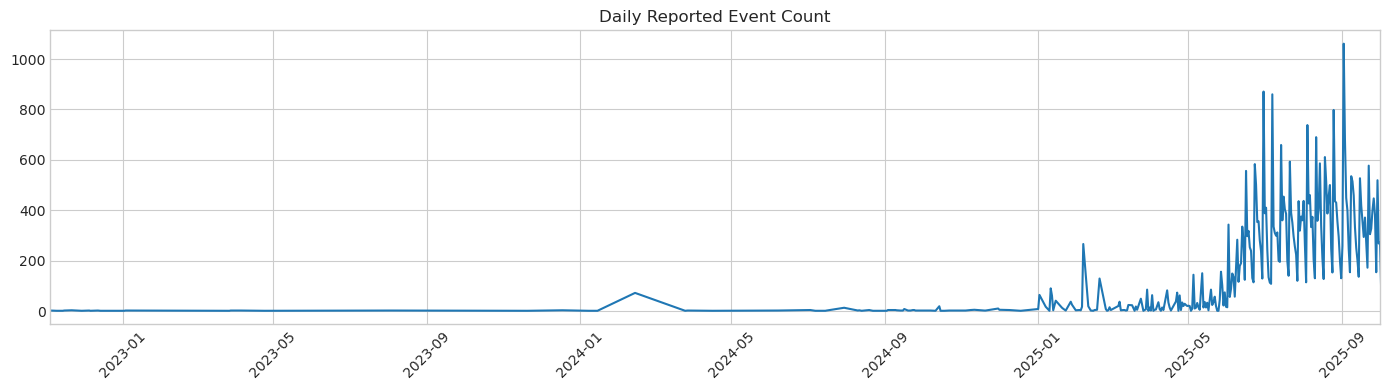

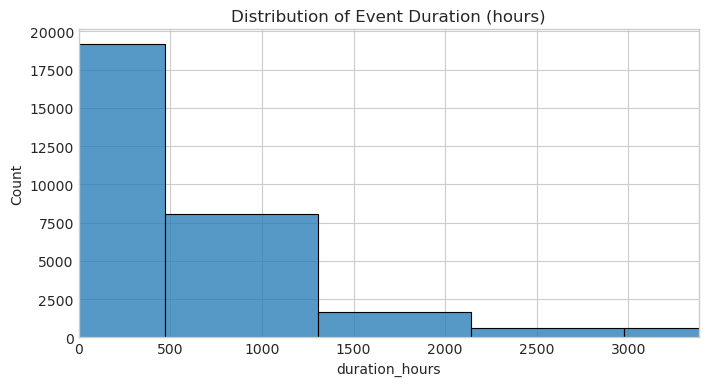

Age (hours) stats:
count    46488.000000
mean      1299.791716
std        941.083140
min         -1.902275
25%        636.267447
50%       1200.267725
75%       1917.288558
max      22151.751614
Name: age_hours, dtype: float64


In [13]:
# Temporal distributions
if 'Reported_dt' in events_df.columns:
    events_df['reported_date'] = events_df['Reported_dt'].dt.date
    daily_counts = events_df.groupby('reported_date').size().reset_index(name='count')
    plt.figure(figsize=(14,4))
    plt.plot(daily_counts['reported_date'], daily_counts['count'])
    plt.xlim(daily_counts['reported_date'].min(), date.today())
    plt.title('Daily Reported Event Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if 'duration_hours' in events_df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(events_df['duration_hours'].dropna(), bins=50)
    plt.title('Distribution of Event Duration (hours)')
    plt.xlim(0, events_df['duration_hours'].quantile(0.95))
    plt.show()

if 'age_hours' in events_df.columns:
    print('Age (hours) stats:')
    print(events_df['age_hours'].describe())

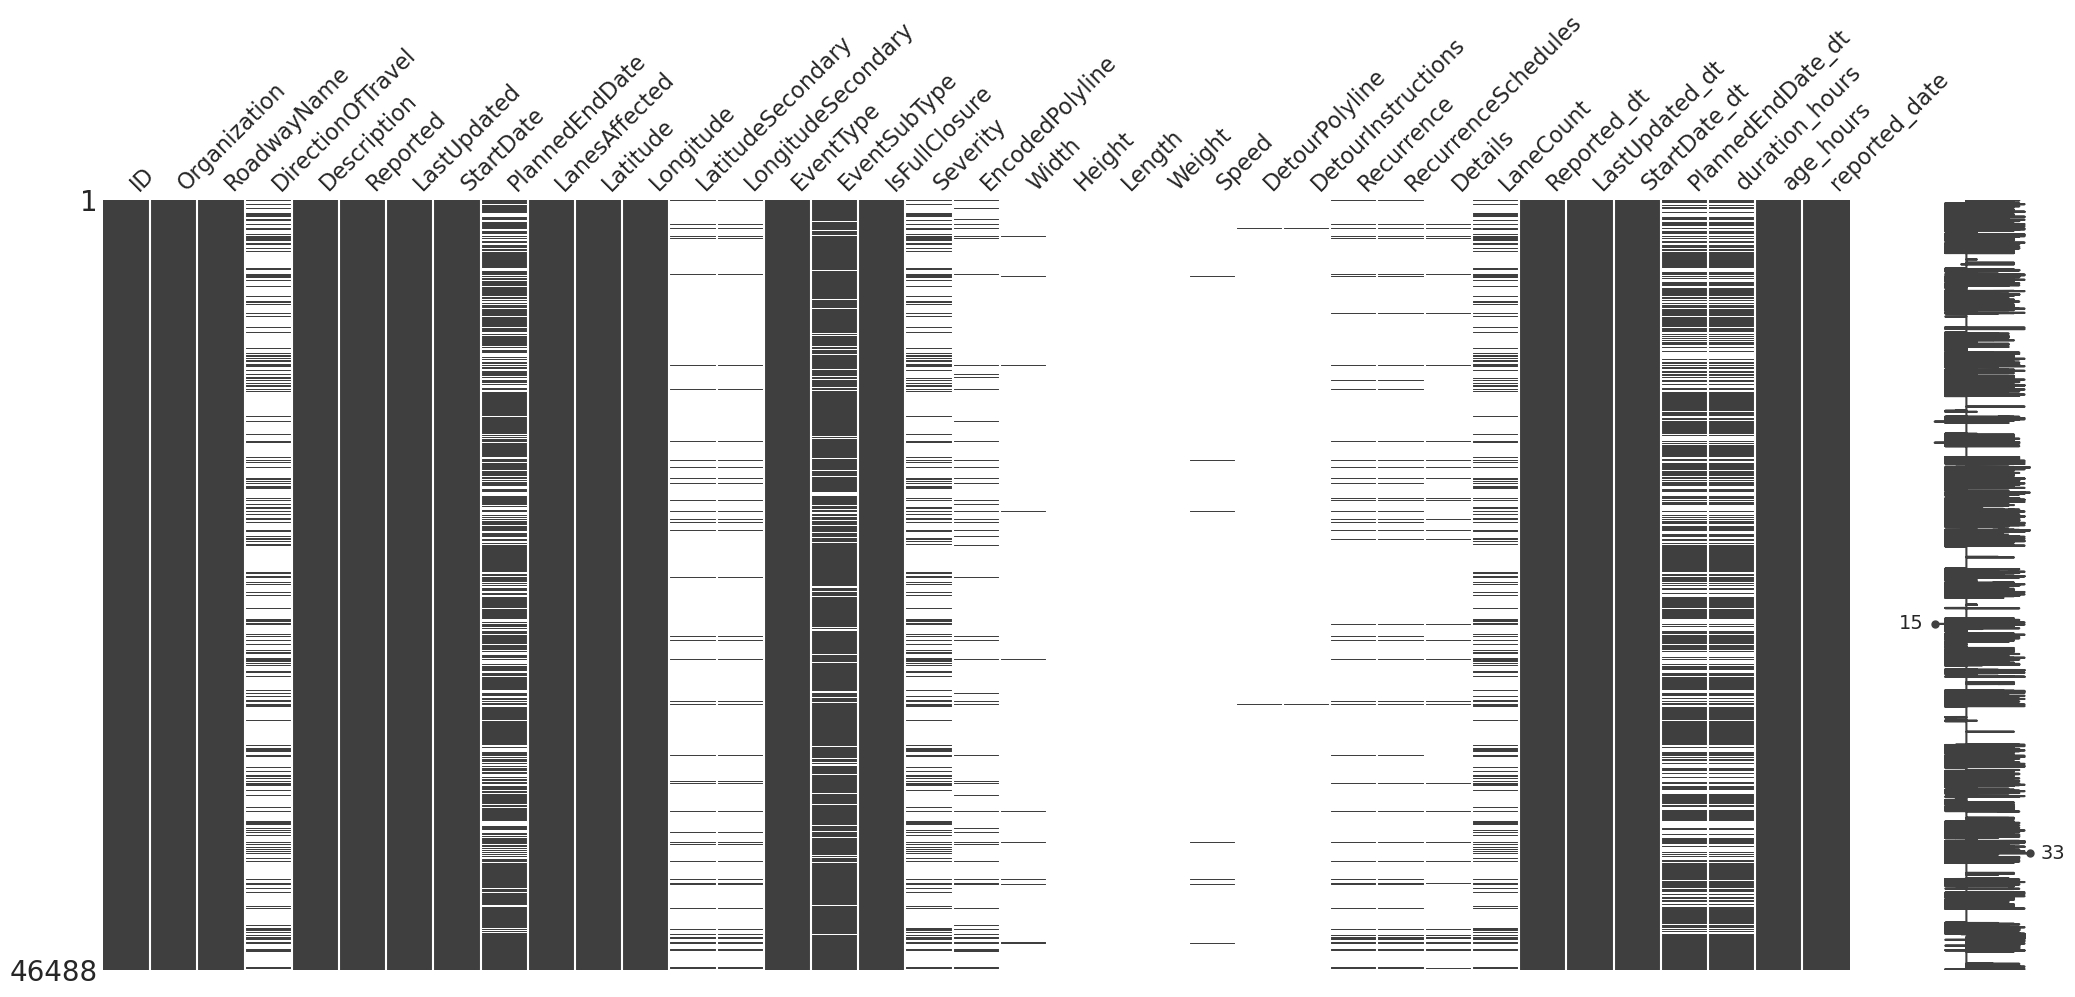

In [15]:
import missingno as msno
msno.matrix(events_df)
plt.show()

In [17]:
# separate events_df by event type and save to parquet files
# Optional: write each subset to parquet (fast & compressed)
out_dir = Path('../database')
out_dir.mkdir(parents=True, exist_ok=True)
event_groups = events_df.groupby("EventType", dropna=False)
for etype, df_sub in event_groups:
    safe = ''.join(ch if ch.isalnum() else '_' for ch in str(etype))[:40]
    print(safe)
    df_sub.to_parquet(out_dir / f'events_{safe}.parquet', index=False)

print('Saved:', len(event_groups), 'files to', out_dir)

accidentsAndIncidents
closures
restrictionClass
roadwork
specialEvents
Saved: 5 files to ../database


In [2]:
df_acc = pd.read_parquet('../database/events_accidentsAndIncidents.parquet')
df_clo = pd.read_parquet('../database/events_closures.parquet')
df_roa = pd.read_parquet('../database/events_roadwork.parquet')

In [8]:
print(len(df_acc), len(df_clo), len(df_roa))

15063 876 30397


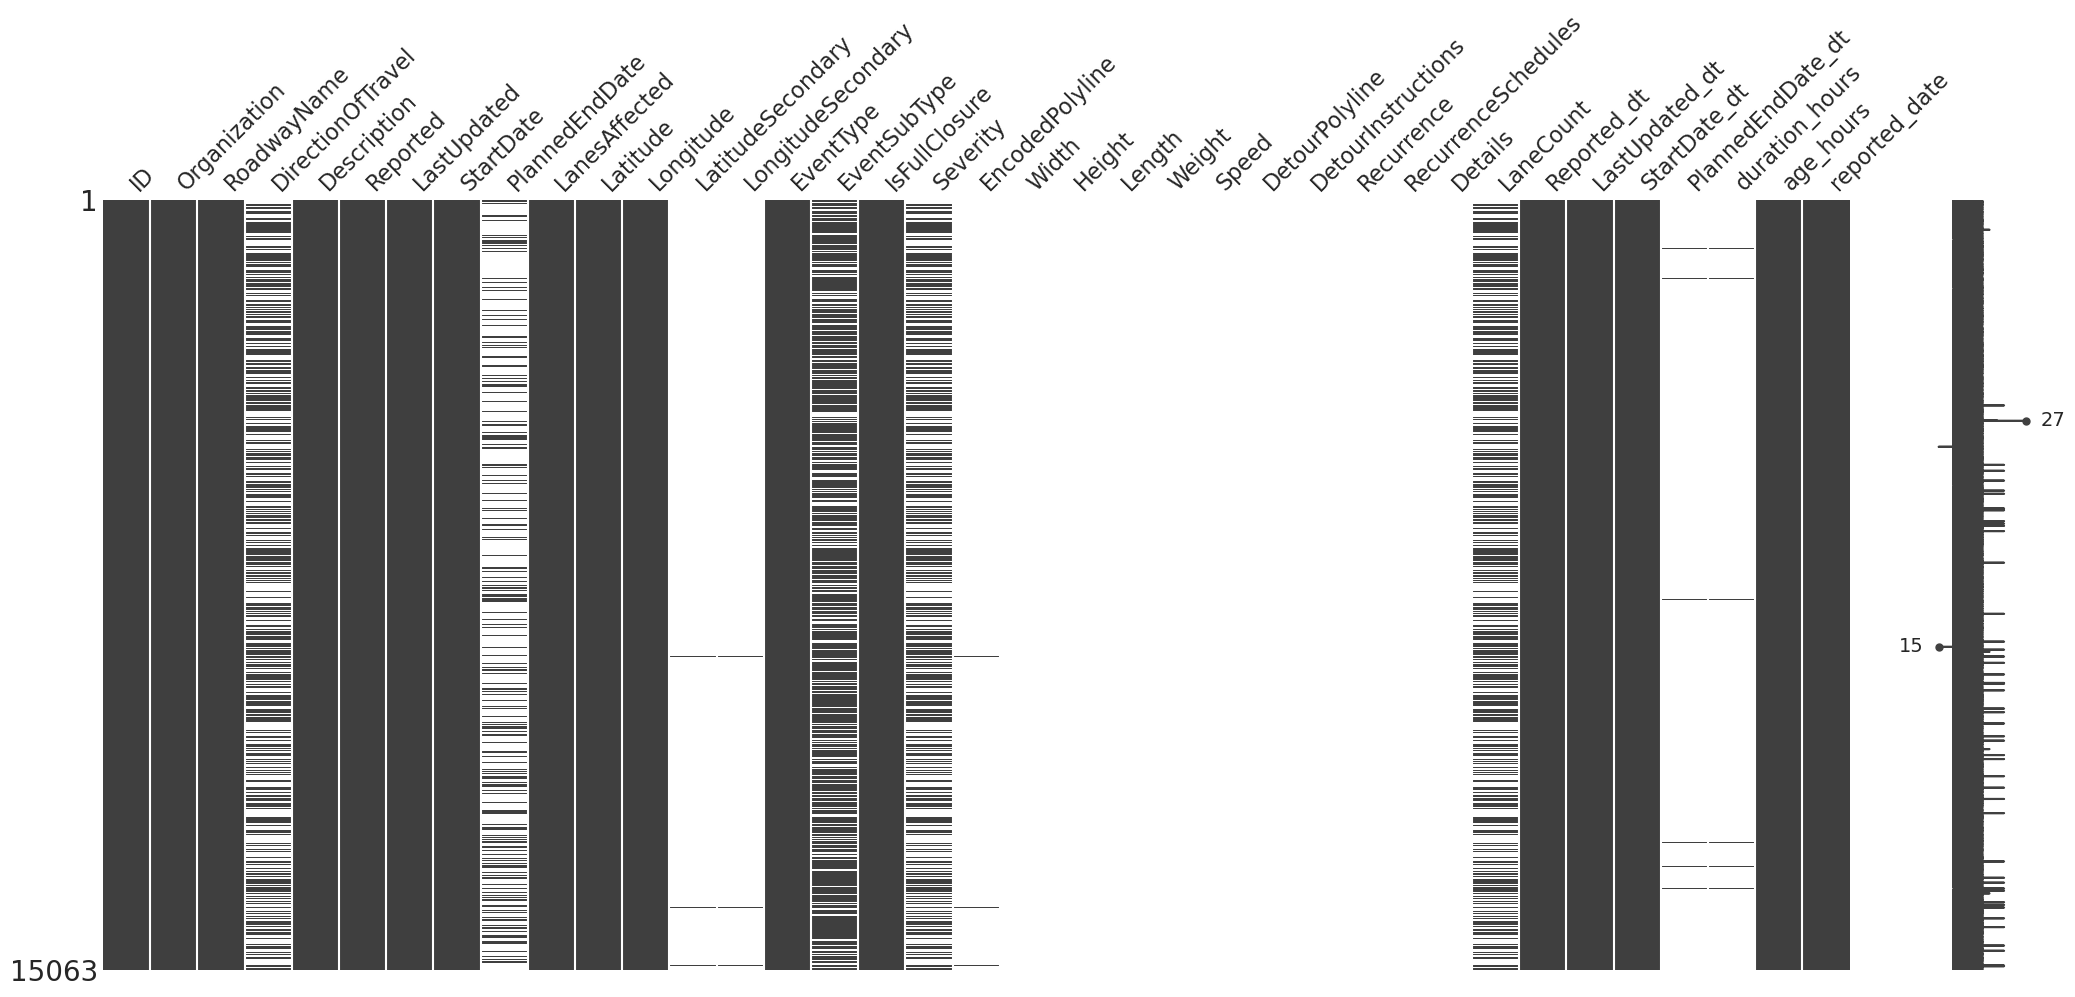

In [21]:
msno.matrix(df_acc)
plt.show()

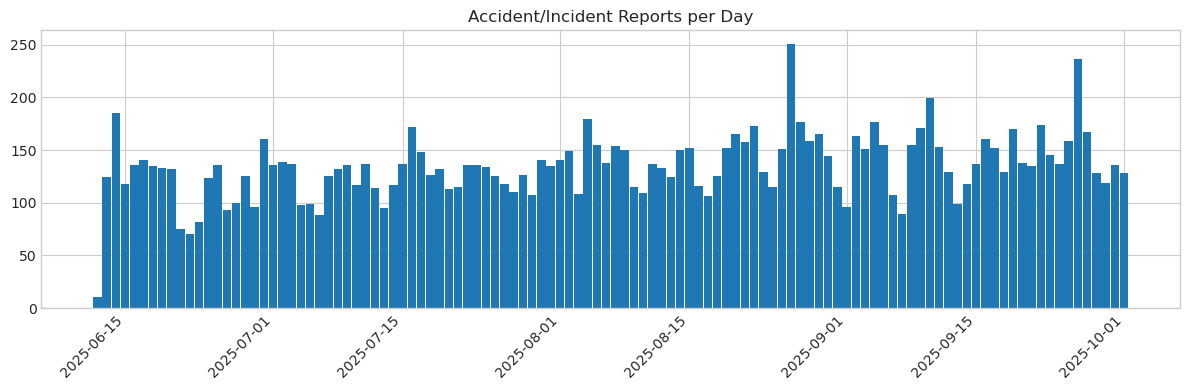

In [32]:
daily_counts = (df_acc
                .groupby('reported_date')
                .size()
                .rename('count')
                .reset_index())

plt.figure(figsize=(12,4))
plt.bar(daily_counts['reported_date'], daily_counts['count'], width=0.9)
plt.title('Accident/Incident Reports per Day')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

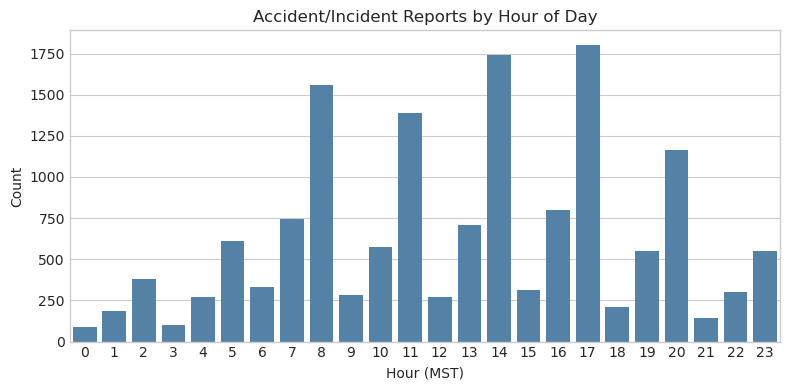

In [37]:
# Hour-of-day distribution (0-23)
from zoneinfo import ZoneInfo
phx_tz = ZoneInfo("America/Phoenix")
if df_acc['Reported_dt'].dt.tz is None:
    local_series = (df_acc['Reported_dt']
                    .dt.tz_localize('UTC')
                    .dt.tz_convert(phx_tz))
else:
    local_series = df_acc['Reported_dt'].dt.tz_convert(phx_tz)

df_acc['reported_hour'] = local_series.dt.hour
hour_counts = df_acc['reported_hour'].value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='steelblue')
plt.title('Accident/Incident Reports by Hour of Day')
plt.xlabel('Hour (MST)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

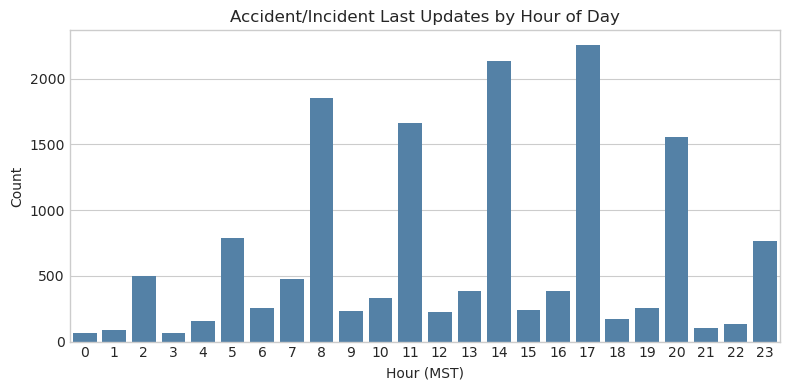

In [39]:
if df_acc['LastUpdated_dt'].dt.tz is None:
    local_series = (df_acc['LastUpdated_dt']
                    .dt.tz_localize('UTC')
                    .dt.tz_convert(phx_tz))
else:
    local_series = df_acc['LastUpdated_dt'].dt.tz_convert(phx_tz)
hour_counts = local_series.dt.hour.value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='steelblue')
plt.title('Accident/Incident Last Updates by Hour of Day')
plt.xlabel('Hour (MST)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

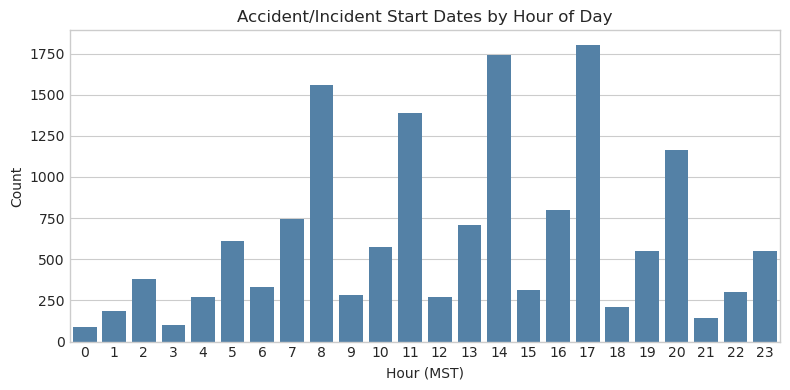

In [38]:
if df_acc['StartDate_dt'].dt.tz is None:
    local_series = (df_acc['StartDate_dt']
                    .dt.tz_localize('UTC')
                    .dt.tz_convert(phx_tz))
else:
    local_series = df_acc['StartDate_dt'].dt.tz_convert(phx_tz)
hour_counts = local_series.dt.hour.value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='steelblue')
plt.title('Accident/Incident Start Dates by Hour of Day')
plt.xlabel('Hour (MST)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 5. Categorical Distributions & Cross Tabs


Top EventSubType:


EventSubType
None                       3912
AccidentIncident           3767
Crash on right shoulder    1255
C34Rshoulder                888
accident                    378
DebrisRshoulder             285
CrashLshoulder              235
C34Lshoulder                222
crashRlane                  208
debrisLshoulder             191
C34Rlane                    191
animalOnRoadway             182
vehicleOnFire               160
C34exit                     157
crashLlane                  125
Name: count, dtype: int64

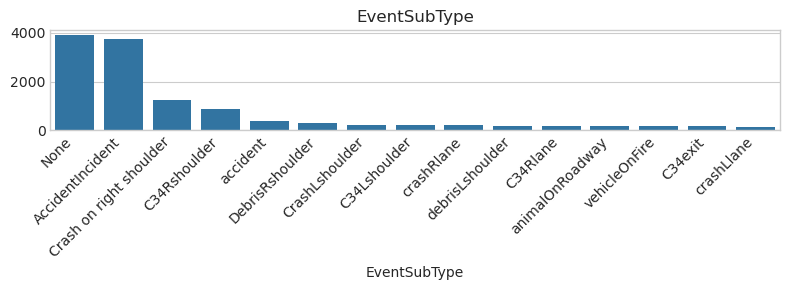


Top Severity:


Severity
None     7679
Minor    5518
None     1711
Major     155
Name: count, dtype: int64

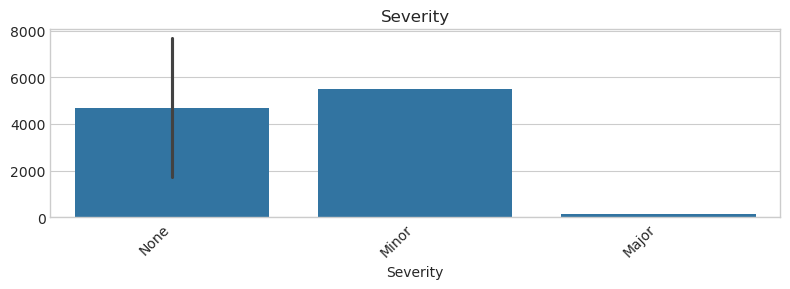


Top DirectionOfTravel:


DirectionOfTravel
None     7679
East     2253
West     2237
North    1462
South    1432
Name: count, dtype: int64

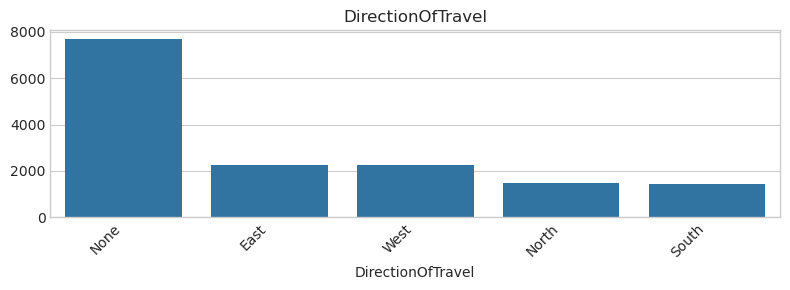


Top IsFullClosure:


IsFullClosure
0    15063
Name: count, dtype: int64

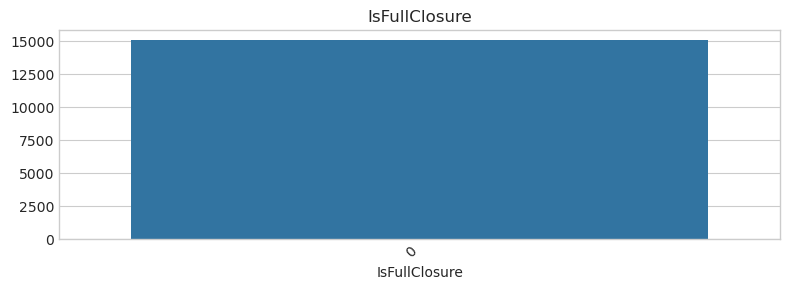

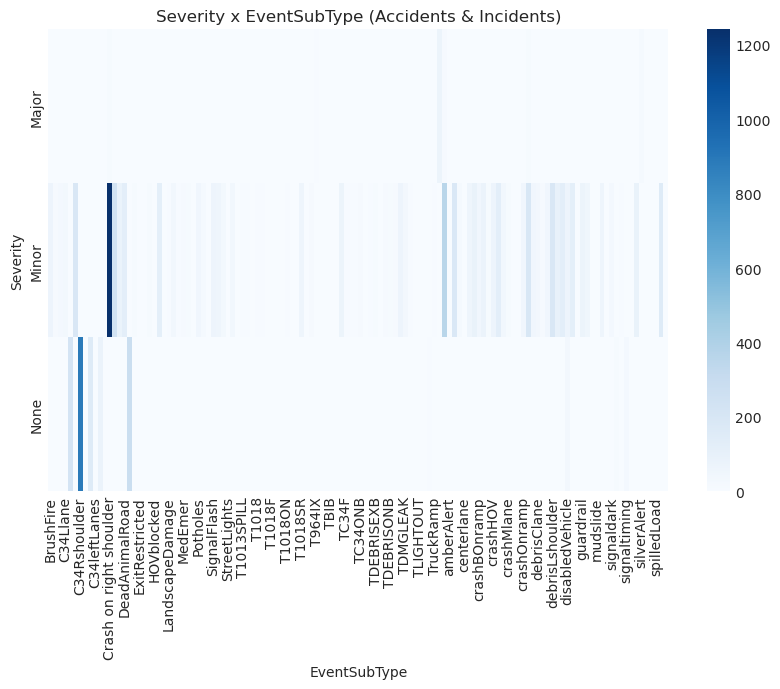

In [42]:
df = df_acc
cat_focus = ['EventSubType','Severity','DirectionOfTravel','IsFullClosure']
for c in cat_focus:
    if c in df.columns:
        vc = df[c].value_counts(dropna=False).head(15)
        print(f"\nTop {c}:")
        display(vc)
        plt.figure(figsize=(8,3))
        sns.barplot(x=vc.index.astype(str), y=vc.values)
        plt.title(c)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Crosstab example: Severity vs EventType
if set(['Severity','EventSubType']).issubset(df.columns):
    ct = pd.crosstab(df['Severity'], df['EventSubType'])
    plt.figure(figsize=(10,6))
    sns.heatmap(ct, annot=False, cmap='Blues', cbar=True)
    plt.title('Severity x EventSubType (Accidents & Incidents)')
    plt.show()

In [49]:
len(df_roa)

30397

## 6. Spatial Preview
Scatter of primary & secondary coordinates (if available).

In [16]:
df.columns

Index(['ID', 'Organization', 'RoadwayName', 'DirectionOfTravel', 'Description',
       'Reported', 'LastUpdated', 'StartDate', 'PlannedEndDate',
       'LanesAffected', 'Latitude', 'Longitude', 'LatitudeSecondary',
       'LongitudeSecondary', 'EventType', 'EventSubType', 'IsFullClosure',
       'Severity', 'EncodedPolyline', 'Width', 'Height', 'Length', 'Weight',
       'Speed', 'DetourPolyline', 'DetourInstructions', 'Recurrence',
       'RecurrenceSchedules', 'Details', 'LaneCount', 'Reported_dt',
       'LastUpdated_dt', 'StartDate_dt', 'PlannedEndDate_dt', 'duration_hours',
       'age_hours', 'reported_date'],
      dtype='object')

In [34]:

df = df_acc.loc[df_acc['EventSubType']== 'AccidentIncident']
# df = df_acc
fig = px.scatter_map(df, lat='Latitude', lon='Longitude', color="Organization",
                     hover_data=['DirectionOfTravel','Description','Reported_dt','RoadwayName','Details'],
                        center=dict(lat=df["Latitude"].mean(), lon=df["Longitude"].mean()), zoom=8)
fig.show()

In [25]:
df_acc.EventType.value_counts()

EventType
accidentsAndIncidents    15063
Name: count, dtype: int64

In [35]:
# df = df_roa.loc[df_roa['EventSubType']== 'AccidentIncident']
df = df_roa
fig = px.scatter_map(df, lat='Latitude', lon='Longitude', color="EventSubType",
                     hover_data=['DirectionOfTravel','Description','Reported_dt','RoadwayName','Details'],
                        center=dict(lat=df["Latitude"].mean(), lon=df["Longitude"].mean()), zoom=8)
fig.show()

In [36]:
df = df_clo
fig = px.scatter_map(df, lat='Latitude', lon='Longitude', color="EventSubType",
                     hover_data=['DirectionOfTravel','Description','Reported_dt','RoadwayName','Details'],
                        center=dict(lat=df["Latitude"].mean(), lon=df["Longitude"].mean()), zoom=8)
fig.show()

## 10. Next Steps / Notes
- Consider integrating with `work_zones` / `daily_counts` from `wzdx.py` if needed
- Add geospatial enrichment (GeoPandas) for county/city joins
- Build dashboard seeds from exported JSON